# Self-study notebook for week 1: Introduction to PyTorch

This notebook shows how we can build simple models for text classification using the [PyTorch](https://pytorch.org) library. We first show an example using a "standard" PyTorch solution, and then show how to do the same thing with [PyTorch Lightning](https://pytorch-lightning.readthedocs.io), which provides some high-level functionality to simplify some chores.

The main purpose here is for you to see the basic structure of PyTorch-based solutions. You will be able to reuse this basic design pattern in later parts of the course. In terms of neural network architectures, we will be keeping it to the basics at this point. Later, we will see several types of NN architectures for working with text that you can "plug" into this solution.

We will *not* cover the very basics of how PyTorch works. There are plenty of tutorials available, for instance [on the PyTorch website](https://pytorch.org/tutorials/). There is also a notebook available [here](http://www.cse.chalmers.se/~richajo/dit866/backup_2019/lectures/l5/PyTorch%20linear%20regression%20demo.ipynb)  (or [here](http://www.cse.chalmers.se/~richajo/dit866/backup_2019/lectures/l5/PyTorch%20linear%20regression%20demo.html) in html), developed for another Chalmers course, that covers the most important fundamental PyTorch concepts such as tensors and optimizers.

Throughout the code, there are some pieces marked `YOUR_CODE_HERE` where the implementation is missing. The idea is that you should fill in these parts. We are keeping it simple at this point and it should be stressed that in almost all cases, a single line of code should be enough – so if you are writing several lines, your solution is likely to be overly complicated.

### Prerequisites

To run this notebook, you will need to have PyTorch installed on the machine where you are running, as well as the Scikit-learn library for some basic preprocessing. See [here](https://pytorch.org/get-started/locally/) for PyTorch installation instructions and [here](https://scikit-learn.org/stable/install.html) for Scikit-learn. Generally, we will not be using scikit-learn much in this course, except for practical utilities such as training/test dataset splitting, but in this introductory example this library will simplify our work a bit.

If you are using Colab, these libraries are already installed. (If you want to run the PyTorch Lightning part, you will have to install this library as well, and this is not available by default on Colab. See instructions below.)

# Case study: language classification

The example we are going to consider is the task of *language classification*: given a written text, try to determine what language the text is written in.

Download [this zip file](http://www.cse.chalmers.se/~richajo/dat450/selfstudy_notebooks/eulangs.zip) and uncompress it. 

In [ ]:
!wget http://www.cse.chalmers.se/~richajo/dat450/selfstudy_notebooks/eulangs.zip
!unzip eulangs.zip
!ls

--2021-11-02 16:55:09--  http://www.cse.chalmers.se/~richajo/dat450/selfstudy_notebooks/eulangs.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8009713 (7,6M) [application/zip]
Saving to: ‘eulangs.zip.3’

eulangs.zip.3       100%[===================>]   7,64M  3,90MB/s    in 2,0s    

2021-11-02 16:55:11 (3,90 MB/s) - ‘eulangs.zip.3’ saved [8009713/8009713]

Archive:  eulangs.zip
replace eulangs_100k.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This file contains 100,000 short texts from European Parliament proceedings, written in 22 of the languages of the European Union. (The EU has [24 official languages](https://en.wikipedia.org/wiki/Languages_of_the_European_Union), but this dataset does not include any texts in Irish or Croatian.) This collection has been extracted from the [Europarl](https://www.statmt.org/europarl/) dataset, often used for the development of machine translation systems.

Here is an example of how the file is structured:

```
fr:Intitulé: Primes brutes émises au titre de l'assurance directe, primes de contrat ...
da:For at der skal kunne ydes tilskud efter artikel 108 i finansforordningen, skal der ...
el:Μέλος της Επιτροπής
```

In the file, each row contains an example. Each row starts with a two-letter language code in the [ISO 639-1](https://en.wikipedia.org/wiki/ISO_639-1) format, and then the text follows after a colon separator.

**Common-sense sanity test**: which languages are probably going to be the easiest to recognize?

**Your work:** read the dataset and store it as a list of documents `X` and a list of labels `Y`. (This task is an exception to what we wrote above that `YOUR_CODE_HERE` should be replaced by a single line of code. You might be able to solve this with a one-liner, but the code will probably be more readable if you use more lines.) 

In [17]:
def read_texts(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            Y.append(line[0:2])
            X.append(line[3:])
    return X, Y

In [18]:
X, Y = read_texts('eulangs_100k.txt')

We then use a utility in the scikit-learn library to randomly split the dataset into training and test sections. (Later on, we will use the same utility to set aside a validation part.)

In [19]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

You can now inspect some of the instances. For instance, the first document in the training set is in [Estonian](https://en.wikipedia.org/wiki/Estonian_language).

In [20]:
Xtrain[0], Ytrain[0]

('17. Käesolevat dokumenti võib muuta osaliste konsensuse alusel tehtud otsusega.\n',
 'et')

... and the first document in the test set is in English.

In [21]:
Xtest[0], Ytest[0]

('FD3 Flow divider (Figure 17)\n', 'en')

# Representing documents

The idea of *representation* is arguably the most crucial concept of this course. The idea is that the object that we are working with (in this case a text) should be represented in a way so that its useful information is "obvious" to the machine learning system. Concretely, this typically means that each document will be stored as a vector in some high-dimensional vector space, and in a good representation for a classification task (in our case, determining the language of the text), the different classes will be located in different regions of this space.

In the course, we will consider many different approaches to representing words and documents. Generally, these representations will be *learned* from data.

### Using scikit-learn to build a count-based document representation

However, right now we are going to keep things simple and use a straightforward *count-based* representation. You have probably seen this approach used in previous machine learning courses.

We define a vector space where each dimension represents how many times we observed a certain character. For instance, given the text *kreuzschlitzschraubenzieher*, one of the dimensions will represent the character `z` and its value will be 3 in this case.

The scikit-learn library provides some useful utilities to compute such count-based representations. The [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) will give us the desired result. We will also apply a [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) that normalizes each example to unit norm (that is, its Euclidean length is 1). The reason is that we want the representation to be stable even if there is much variation in the length of the documents. Finally, we also import [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html), which is simply a utility to combine several steps.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

document_representation = make_pipeline(CountVectorizer(analyzer='char'), Normalizer())
document_representation.fit(Xtrain, Ytrain)
Xtrain_encoded = document_representation.transform(Xtrain)

**Self-check:** The shape of this output is 80000 x 252. What does this mean? Make sure you understand what the rows and columns represent.

In [23]:
Xtrain_encoded.shape

(80000, 253)

The output of a CountVectorizer is a [*sparse* matrix](https://en.wikipedia.org/wiki/Sparse_matrix#Storing_a_sparse_matrix). That is, only nonzero elements are stored explicitly, together with their positions. For instance, if we print the representation of the first document, we get

In [24]:
print(Xtrain_encoded[0])


  (0, 0)	0.046726931351599776
  (0, 1)	0.420542382164398
  (0, 15)	0.09345386270319955
  (0, 18)	0.046726931351599776
  (0, 24)	0.046726931351599776
  (0, 38)	0.23363465675799888
  (0, 39)	0.046726931351599776
  (0, 41)	0.09345386270319955
  (0, 42)	0.420542382164398
  (0, 44)	0.046726931351599776
  (0, 45)	0.046726931351599776
  (0, 46)	0.14018079405479933
  (0, 48)	0.14018079405479933
  (0, 49)	0.1869077254063991
  (0, 50)	0.09345386270319955
  (0, 51)	0.14018079405479933
  (0, 52)	0.23363465675799888
  (0, 56)	0.420542382164398
  (0, 57)	0.32708851946119843
  (0, 58)	0.32708851946119843
  (0, 59)	0.09345386270319955
  (0, 88)	0.046726931351599776
  (0, 105)	0.046726931351599776


This sparse format does not work well with neural network libraries such as PyTorch or TensorFlow, so we need to convert it into a straightforward NumPy matrix that also stores the zeroes. This is done simply by calling `.toarray()` on the sparse matrix.

There is another technicality we need to keep in mind here. The matrix we have here uses [double-precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) floating point numbers (each number uses 64 bits). However, it is common practice when working with neural networks to use a lower precision: 32 or even 16 bits. To convert into [single precision](https://en.wikipedia.org/wiki/Single-precision_floating-point_format) (32 bits), we can call `.astype(np.float32)`.

In [25]:
import numpy as np

Xtrain_matrix = Xtrain_encoded.toarray().astype(np.float32)

Repeat the preprocessing steps for the test set as well. ***Note:*** Don't call `fit` once again! We want the training and test sets to live in the same vector space.

In [26]:
Xtest_encoded = document_representation.transform(Xtest)

(20000, 253)

### Encoding the class labels

Now that we have taken care of the *input* part of the dataset (the documents), let's deal with the *output* (the language codes). This is a bit simpler. We just have to map each language code (such as `en` for English) to an integer.

Again, we will use a utility from scikit-learn here. A [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) creates a mapping between class labels and their corresponding integer indices. As we saw for the document encoding above, we first need to `fit` the label encoder and then call `transform` to get the output for the training and test sets.

In [27]:
from sklearn.preprocessing import LabelEncoder
lblenc = LabelEncoder()
lblenc.fit(Ytrain)
Ytrain_enc = lblenc.transform(Ytrain)
Ytest_enc = lblenc.transform(Ytest)

# Building a text classifier in PyTorch

Let's first import the PyTorch library:

In [28]:
import torch

We can check whether a GPU is available. The models we are going to work with in this example are so simple that a GPU won't make much of a difference, but in future examples and assignments, using a GPU will give us a massive speed improvement.

If you are working on Colab and you see `False` here, you have probably forgotten to set your runtime type to GPU.

In [29]:
torch.cuda.is_available()

False

Before we implement the text classifier, we will define an object that will store different types of information that defines the classifier's behavior, including [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_%28machine_learning%29) controlling the model and the training process.

In [30]:
class ClassifierParameters:
    """Container class to store the hyperparameters that control the training process."""

    # Proportion of data set aside for validation.
    val_size = 0.2
    
    # Computation device: 'cuda' or 'cpu'
    device = 'cpu'

    # Number of hidden units in the neural network.
    n_hidden_units = 64
    
    # Number of training epochs.
    n_epochs = 25

    # Size of batches: how many documents to process in parallel.
    batch_size = 512

    # Learning rate in the optimizer.
    learning_rate = 5e-3

    # Weight decay (L2 regularization) in the optimizer (if necessary).
    decay = 0
    
    # Dropout probability (if necessary).
    dropout = 0

### Implementing the classifier

Now, let's do the heavy lifting!

We create a class `NNClassifier` that contains everything we need to train the model and run it on new examples. The centerpiece is the training loop, but there are also some steps of initialization, etc. Most of the structure is in place, but there are some crucial pieces missing that you will have to provide.

Note that this code has been written with a modular design so that it is agnostic about what kind of neural network model we are using. The user will have to provide a [factory function](https://en.wikipedia.org/wiki/Factory_%28object-oriented_programming%29) that creates the neural network. We will define this later.

#### Preprocessing steps: `preprocess`

In the preprocessing steps, we will typically do various types of encoding of the datasets we are using. In this case, we have already preprocessed the datasets and stored them as NumPy matrices, but in later examples and assignments, this step will typically also do vocabulary management, etc.

The other thing we will do here is to prepare the *data loaders*. You might have read about datasets and data loaders in a [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), or you can read the official documentation [here](https://pytorch.org/docs/stable/data.html). To summarize, the main purpose of a data loader is to go through a dataset and create [*minibatches*](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) (or more commonly, just "batches").

To create the batches, a data loader needs a *dataset*. There can be different types of datasets, some of which might be backed by a file system or a database. However, to make a long story short, for our purposes a dataset is simply an object that can be indexed like a regular list to give an input/output pair for training or validation.

**Your work**: 
- Set up two data loaders: one for the training set and one for the validation set.

#### Main training/validation loop: `fit`

This is the main method of our text classifier and it will create a new neural network model and train it. We first carry out some initial steps:
- Call `preprocess` discussed above.
- Create the neural network model, using the factory function.
- Move the model onto the GPU (if you are using a GPU).
- Create a [*loss function*](https://en.wikipedia.org/wiki/Loss_functions_for_classification); for a classification task, this will often be the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
- Create an *optimizer*. In PyTorch, an optimizer updates a model, depending on the gradients of the model's weights with respect to the loss. Typical optimizers include [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

We then enter the training loop, which will be run for a number of *epochs* (iterations). In each epoch, we will call the utility function `epoch`, discussed below. This will be done separately for the training set and validation set.

**Your work**: 
- Move the model to the appropriate device, 
- Create a loss function. 
- Create an optimizer.

#### Running the model for one training epoch: `epoch`

The `epoch` method is where we see most of the machinery. Here, we will go through the batches in the training or validation set, compute the model outputs and the loss function. We will also keep track of some statistics: the overall loss and the prediction accuracy. If we are processing the training set (that is: not the validation set), we will also update the model here after each batch.

**Your work**:
- Compute the outputs from the model.
- Compute the loss. 
- If we are training: compute the weight gradients and then update the model.

#### Making predictions for a new dataset: `predict`

After a model has been trained, we can apply it to new instances. This code will go through the new data in a similar fashion as we did in `epoch`, except that there are no gold-standard outputs Y here. In the end, we return all the predicted outputs.

**Your work**:
- Create a data loader for the new instances. Keep in mind that there is no Y part here.
- For a batch, move the tensor to the GPU if necessary.
- Compute the model output.

In [51]:
from torch import nn
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
from collections import defaultdict

class NNClassifier:
    """A classifier based on a neural network."""
    
    def __init__(self, params, model_factory):
        self.params = params
        self.model_factory = model_factory
        
    def preprocess(self, X, Y):
        """Carry out the document preprocessing, then build `DataLoader`s for the 
           training and validation sets."""

        # Split X and Y into training and validation sets. We
        # apply the utility function we used previously.
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=self.params.val_size, random_state=0)        
        
        # As discussed above, a dataset simply needs to behave like a list: it should
        # be aware of its length and be able to index:
        # dataset[position] should give an x,y pair (input and output).
        # This means that we can simply use lists here!
        train_dataset = list(zip(Xtrain, Ytrain))
        val_dataset = list(zip(Xval, Yval))
        
        # Now, create the data loaders. The user parameters specify the batch size.
        self.train_loader = DataLoader(train_dataset, batch_size=self.params.batch_size, shuffle=True)
        self.val_loader = DataLoader(train_dataset, batch_size=self.params.batch_size)
        
        
    def fit(self, X, Y):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        self.preprocess(X, Y)

        self.input_size = X.shape[1]
        self.n_classes = len(set(Y))        
        
        # Create a new model using the previously provided factory.
        # The assumption is that this is a PyTorch neural network that
        # takes inputs and makes outputs of the right sizes.
        self.model = self.model_factory(self)
        
        # If we're using a GPU, put the model there.
        # YOUR_CODE_HERE
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss_func = torch.nn.CrossEntropyLoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), self.params.learning_rate)

        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        
        # Use the tqdm library to get a progress bar. The progress bar object can be used like
        # any generator-like object.
        progress = tqdm(range(par.n_epochs), 'Epochs')
        
        # Go through the dataset for a given number of epochs.
        for epoch in progress:

            t0 = time.time()
            
            # Set the model in training mode. This affects some components that 
            # behave differently at training and evaluation time, such as dropout
            # and various types of normalization (e.g. batch normalization). It is good
            # practice to include this even if you don't use any dropout or normalization.
            self.model.train()
            
            # Run the model on the training data. The model will be updated after each batch.
            # See below for the implementation of `epoch`.
            train_loss, train_acc = self.epoch(self.train_loader, optimizer)
                        
            # Set the model in evaluation mode, again affecting dropout and normalization modules.
            self.model.eval()

            # Run the model on the validation data. For somewhat improved efficiency, we disable 
            # gradient computation now since we are not going to update the model.
            with torch.no_grad():
                val_loss, val_acc = self.epoch(self.val_loader)
            
            t1 = time.time()

            # Store some evaluation metrics in the history object.
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['time'].append(t1-t0)
            
            # Show validation-set metrics on the progress bar.
            progress.set_postfix({'val_loss': f'{val_loss:.2f}', 'val_acc': f'{val_acc:.2f}'})
        
        
    def epoch(self, batches, optimizer=None):
        """Runs the neural network for one epoch, using the given batches.
        If an optimizer is provided, this is training data and we will update the model
        after each batch. Otherwise, this is assumed to be validation data.
        
        Returns the loss and accuracy over the epoch."""
        n_correct = 0
        n_instances = 0
        total_loss = 0
        
        # We iterate through the batches (typically from a data loader).
        # This will give us X, Y pairs, containing the input and output parts
        # of this batch, respectively.
        for Xbatch, Ybatch in batches:

            # Xbatch is a tensor of shape (batch_size, input_size).
            # Ybatch has the shape (batch_size).
                        
            # If we're using the GPU, move the batch there.
            #Xbatch = Xbatch.to(self.params.device)
            #Ybatch = Ybatch.to(self.params.device)
            
            # Compute the predictions for this batch.
            scores = self.model(Xbatch)
            
            # If the previous step was implemented correctly, your scores
            # tensor should have the shape (batch_size, n_classes).
            
            # Compute the loss for this batch. Note: various loss functions 
            # behave differently, depending on whether they aggregate or not 
            # (that is, by summing or averaging). 
            # In the end, the loss value needs to be a single number so
            # that we can compute gradients and update our model later.
            loss = self.loss_func(scores, Ybatch)

            total_loss += loss.item()

            # Compute the number of correct predictions, for the accuracy.
            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()
            n_instances += Ybatch.shape[0]

            # If this is training data, update the model.
            if optimizer:
                # Reset the gradients.
                optimizer.zero_grad()
                # Run the backprop algorithm to compute the new gradients.
                loss.backward()
                # Update the model based on the gradients.
                optimizer.step()
           
        return total_loss/len(batches), n_correct/n_instances
        
        
    def predict(self, X):
        """Run a trained classifier on a set of instances and return the predictions."""
        
        # Build a DataLoader to generate the batches, as above except that now we don't have Y.
        loader = DataLoader(X, batch_size=self.params.batch_size)

        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        outputs = []
        with torch.no_grad():
            for Xbatch in loader:
                # Move the batch onto the GPU if we are using one.
                #YOUR_CODE_HERE
                
                # Compute the output scores.
                scores = self.model(X)
                # scores should have the shape (batch_size, n_classes).
                
                # For each row, find the position of the highest score. This represents
                # the model's guess for this instance.
                # The output will have the shape (batch_size).
                guesses = scores.argmax(dim=1)

                # Move the result back onto the CPU and convert into a NumPy array,
                # and keep the result for later.
                outputs.append(guesses.cpu().numpy())
                
            # Finally, concatenate all output arrays.
            return np.hstack(outputs)


In the implementation above, we left the definition of the neural network architecture unspecified. Now, let's write the factory function that creates a NN model.

This can be any kind of PyTorch neural network: you just need to make sure that you use the right input and output sizes. The input size is equal to the number of columns in the input matrix: on our case, the number of different characters we have observed. The output size is equal to the number of classes: the number of languages.

Probably, the simplest option to start with is a single linear layer ([`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). Then you can try something more complex: the most natural solution will then probably be a [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), which will allow you to stack several layers on top of each other.

Note that our feature representation is rather primitive, and it might be the case that a complex deep model will not give better results than a linear model. The point is simply to understand how things fit together, so it can still be useful to play around with a variety of models.

If you need anything from the user-specified parameters, you can access them via `clf.param`.

In [33]:
def make_model(clf):
    input_size = clf.input_size
    output_size = clf.n_classes
    model = nn.Linear(input_size, output_size)
    return model

### Training the classifier
Now, we have all the pieces we need and can finally train the text classifier!

Note that we first call `torch.random.manual_seed` with a fixed number. This is to initialize random number generators and the reason we do this is for reproducibility: we will get the same result each time we run the code.

In [52]:
# Initialize the random number generator.
torch.random.manual_seed(0)

# Create the classifier.
clf = NNClassifier(ClassifierParameters(), make_model)

# Train the classifier.
clf.fit(Xtrain_matrix, Ytrain_enc)

Epochs: 100%|███████████████████| 25/25 [00:17<00:00,  1.46it/s, val_loss=0.73, val_acc=0.84]


We stored the values of the evaluation metrics after each epoch and we can now plot these metrics. We use standard Python plotting functionality. Optionally, read up on how to use [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) with PyTorch.

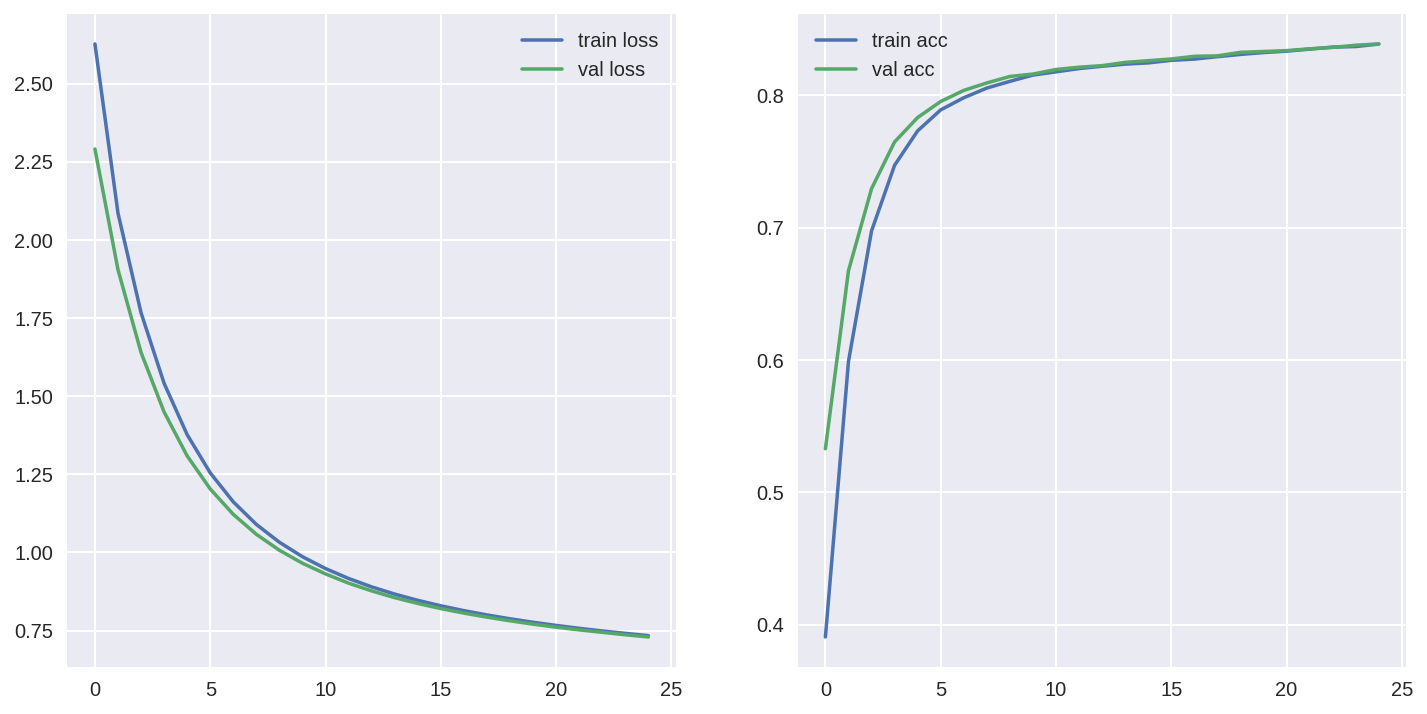

In [54]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

x = range(len(clf.history['train_loss']))
fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(x, clf.history['train_loss'], x, clf.history['val_loss']);
ax[0].legend(['train loss', 'val loss']);
ax[1].plot(x, clf.history['train_acc'], x, clf.history['val_acc']);
ax[1].legend(['train acc', 'val acc']);

### Optional tasks

Add some code to monitor the model's performance while you are training, and each time you see an improvement, save the current state of the model to a file. Also do *early stopping*: if we fail to get an improvement for a given number of epochs, terminate training.

### Evaluation and analysis

We predict the outputs for the test set and compute the [accuracy](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) metric to evaluate the quality of the predictions. This is simply the proportion of correct answers and we use the function [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) from scikit-learn.

In [ ]:
from sklearn.metrics import accuracy_score

pred = clf.predict(Xtest_matrix)
accuracy_score(Ytest_enc, pred)

Here is some code to classify a single text. Keep in mind that the classifier works on batches, not single instances, so we need to put the text into a list for input and the output will also be a list. We use the `LabelEncoder`'s `inverse_transform` to convert the output integer index back into a language label.

In [ ]:
testtext = 'as vitrines são vitrines'
#testtext = 'kreuzschlitzschraubenzieher'
#testtext = 'På Norra älvstranden (Hisingens södra älvstrand) pågår ett omfattande planarbete'

X_one = document_representation.transform([testtext]).toarray().astype(np.float32)
Y_one = clf.predict(X_one)
lblenc.inverse_transform(Y_one)[0]

Play around with different input texts and see how well the classifier works for them. You may also look at individual instances in the validation set or test set.

**Reflection.** Can you think of properties that make a text easy to classify?

**More reflection.** If you think of the way that we prepared the data for this task, how do you think that our approach is limited? Specifically, think of how we converted the texts into a matrix. How could this be improved to compute the matrix in a smarter way to improve performance? What are the technical challenges with doing that?

# Working with PyTorch Lightning

**If you are happy with the code above, this part can be skipped. All examples in the course will be given in straightforward PyTorch code and while PyTorch Lightning can simplify your code, it is not required for understanding anything in the course.** 

While Pytorch offers the user detailed control over all aspects of the training process, you might find the implementation above somewhat tedious. Why do we need to write boilerplate code to do trivial things like running the training loop, moving tensors back and forth, or going through the batches?

[PyTorch Lightning](https://www.pytorchlightning.ai/) is a library that works on a somewhat higher level of abstraction compared to regular PyTorch, and the purpose is exactly to get rid of "trivial" parts such as training loops, so that you can focus on the interesting parts that are specific for the problem you are trying to solve and the models you are working with.

**Note for Colab users:** In Colab, this library has to be installed manually. Keep in mind that libraries will have to be reinstalled each time you restart a Colab notebook.

In [ ]:
!pip install pytorch-lightning 

In [ ]:
import pytorch_lightning as pl

### Main concepts in PyTorch Lightning

The most important building block used in PyTorch Lightning is the [`LightningModule`](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html). This is the component that stores the neural network model and defines how it should be applied. It can be seen as an extension of the regular PyTorch [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

To be able to train and evaluate, we need to provide some data as input. PyTorch Lightning wraps data processing in a component called a [`LightningDataModule`](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html). The data module will carry out the necessary data preprocessing and create data loaders that will help us with minibatching (as in our implementation above).

Finally, to do the actual work and train the model, we use a [`Trainer`](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), which carries out the initialization and run the training loops. This includes the parts we referred to as "boilerplate" above and does not have to be implemented by the user.

### Implementing the `LightningDataModule`

Let's start with the data module. We don't need to do any preprocessing here, since we did the necessary groundwork previously, so we just need to split the dataset and create the data loaders.

**Your work.**
- Split the provided data into training and validation parts.
- Then implement two methods `train_dataloader` and `val_dataloader` that return data loaders for the training and validation parts, respectively.

In [ ]:
class ExampleDataModule(pl.LightningDataModule):

    def __init__(self, X, Y, param):
        super().__init__()
        self.param = param
        YOUR_CODE_HERE       

    def train_dataloader(self):
        YOUR_CODE_HERE

    def val_dataloader(self):
        YOUR_CODE_HERE

### Implementing the `LightningModule`

Now, let's implement the `LightningModule`. To have a place to store hyperparameters and other configuration 
settings, we use the same `ClassifierParameters` as above.

**Your work.**
- Initialize the model structure, the loss function, and the optimizer.
- Carry out the computations for training and validation steps.
- Predict the outputs at test time.

In [ ]:
class ExampleModule(pl.LightningModule):

    def __init__(self, data, params):
        super().__init__()

        self.params = params        

        n_inputs = data.Xtrain.shape[1]
        n_outputs = len(set(data.Ytrain))
        
        # Build the model architecture. If you want, you can use a factory function here as above,
        # or you can keep it simple and create the model directly.
        self.model = YOUR_CODE_HERE

        # Loss function.
        self.loss_func = YOUR_CODE_HERE
                 
    def configure_optimizers(self):
        """Set up the optimizers used to tune the model weights."""
        optimizer = YOUR_CODE_HERE
        return optimizer                        
            
    def training_step(self, batch, batch_idx):
        """Apply the model to one training batch and compute the loss."""
        # This method needs to return the loss, so that we can compute gradients and update the model.
        x, y = batch
        model_output = YOUR_CODE_HERE
        # As in our previous implementation, model_output should be of 
        # the shape (batch_size, n_outputs) here.
        loss = YOUR_CODE_HERE
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """Apply the model to one validation batch."""
        # This method does not need to return anything, but you will probably want to
        # log some evaluation metric here.
        x, y = batch
        model_output = YOUR_CODE_HERE
        loss = YOUR_CODE_HERE
        self.log('val_loss', loss)

    def forward(self, x):
        """Predict the outputs for the given batch `x`."""
        model_output = YOUR_CODE_HERE
        # Again, model_output should be (batch_size, n_outputs). We
        # aggregate over the second dimension to get the output.
        return model_output.argmax(dim=1)        
        

### Running the `Trainer`

We now have the building blocks to train our classifier with PyTorch Lightning.

The main things we need to do is just to initialize the `LightningDataModule` and `LightningModule` we implemented above, and then run a `Trainer`.

In [ ]:
def train_with_lightning():
    # Like before, we create an object to hold our parameters.
    param = ClassifierParameters()

    # Initialize the random seed for reproducibility.
    torch.random.manual_seed(0)

    # Create the data module you defined above.
    data_module = YOUR_CODE_HERE

    # Create the module.    
    module = YOUR_CODE_HERE

    # Create a callback for early stopping
    es = pl.callbacks.EarlyStopping(monitor='val_loss')
    
    # We can specify how many GPUs we want to use.
    # Alternatively, provide identifiers of which GPUS to use.
    gpus = None if param.device == 'cpu' else 1
    
    # Create the trainer object that will run the training loop.
    # Set progress_bar_refresh_rate=0 if you find the progress bar annoying.
    # Set weights_summary=None if you want to get rid of the architecture summary.
    trainer = pl.Trainer(gpus=gpus, callbacks=[es], max_epochs=param.n_epochs)
    
    # Finally, call the training method!
    trainer.fit(module, data_module)
    
    # To make predictions later, we need to keep the trainer and the module.
    return trainer, module
    
ptl_trainer, ptl_module = train_with_lightning()

### Predicting outputs

Now that we have trained the model, let's just see how to make predictions for new instances.

We first do this for a single instance:

In [ ]:
testtext = "La sfida dell'inclusione raccontata agli studenti da due gemelle di 19 anni affette da una grave disabilità."

# Create a data loader to hold this single instance.
dl = DataLoader(list(document_representation.transform([testtext]).toarray().astype(np.float32)))

# Predict the output.
Y_one = ptl_trainer.predict(ptl_module, dl)[0].cpu().numpy()

# Convert the integer index back into a string.
lblenc.inverse_transform(Y_one)[0]

To predict the outputs for the test set as a whole, we will do basically the same thing. There's only one small technicality here: the `predict` step will return a list of PyTorch tensors, one for each batch. This may be enough in some circumstances, but we will combine them into a single list. (This can be done using PyTorch or NumPy.)

Note that it is not necessary to map the integers back into strings here, since we are just interested in whether the predictions are correct.

In [ ]:
# Create a dataloader for the whole test set.
test_dl = DataLoader(list(Xtest_matrix), batch_size=ptl_module.params.batch_size)

# Compute the outputs for all batches.
batch_outputs = ptl_trainer.predict(ptl_module, test_dl)

# Glue together all the batch outputs.
outputs = torch.hstack(batch_outputs).cpu().numpy()

# Compute the classification accuracy.
accuracy_score(Ytest_enc, outputs)